# In this assignment we learn how to derive a neural network emultor based on the cosmopower emulator (Mancini et al. 2021). Based on this emualtor we perform a PCA data compression.

### For this assignment you need the install cosmopower yourself https://github.com/alessiospuriomancini/cosmopower or you just use the cosmopower_NN.py module that is provided. However in the latter case you need to install tensorflow: https://www.tensorflow.org/install

In [2]:
## Imports all the required libraries 

from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from cosmopower import cosmopower_NN
import matplotlib.pyplot as plt
from numpy.linalg import inv
import tensorflow as tf
import numpy as np
import random

## Preparation: load in the all the 10000 model vectors and corresponding paramters that we use to bulit the emulator.

In [3]:
# Loads the model data vectors
models = np.load("models.npy") 
# Loads the parameter combinations 
parameters = np.load("parameters.npz")
parameters.keys(), models.shape
# Loads the analytical covariance matrix
cov = np.load("covariance.npy") 

#### Divide the models and parameters in a training and test set. 

In [4]:
# Defines the number of samples that will be used for training 
train_sample = range(0, 7000)
# Defines the number of samples that will be used for testing
test_sample = range(7000, 10000)

train_params = {}
test_params = {}

for name in parameters.keys():
    # Makes a dictionary of the training parameters 
    train_params[name] = list(np.array(parameters[name])[train_sample])

for name in parameters.keys():
    # Makes a dictionary of the testing parameters 
    test_params[name] = list(np.array(parameters[name])[test_sample])

# Slices the model data to contain the training features 
train_features = np.load("models.npy")[train_sample]
# Slices the model data to contain the testing features 
test_features = np.load("models.npy")[test_sample]

#### Train the emulator. Reasonable hyper parameres are set already, but test out other settings and comment on what you observe regarding accuracy and speed.

In [19]:
# Normalizes the training features according to a "min-max normalization"
features_modified = (train_features - np.min(train_features, axis = 0)) / (np.max(train_features, 
                    axis = 0) - np.min(train_features, axis = 0))
device = "cpu"

# Provides a map between cosmological parameters and the log-power spectra
cp_nn = cosmopower_NN(parameters = list(parameters.keys()), 
                      modes = np.linspace(-1, 1, train_features.shape[1]), # Provides the k-values 
                      n_hidden = [512, 512, 512, 512], # Specifies the number of nodes for each hidden layer 
                                                       # (4)
                      verbose = True) # Prints messages at different steps 

# Trains the neural network 
with tf.device(device):
    cp_nn.train(training_parameters = train_params, 
                training_features = features_modified, 
                filename_saved_model = "emulator_test", 
                validation_split = 0.1, # Indicates the percent of training set samples used for validation 
                                        # (10%) 
                learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6], # Provides the learning rate for a given 
                                                                 # learning step (5 in total)
                batch_sizes = [500, 500, 500, 500, 500], # Provides the batch size for a given learning 
                                                         # step
                patience_values = [100, 100, 100, 100, 100], # Provides the number of epochs to wait for 
                                                             # early stopping for a given learning step
                max_epochs = [1000, 1000, 1000, 1000, 1000], # Provides the max number of epochs for a 
                                                             # given learning step 
                gradient_accumulation_steps = [1, 1, 1, 1, 1]) # Turns off gradient accumulation by selecting 
                                                               # "1" for each learning step 


Initialized cosmopower_NN model, 
mapping 4 input parameters to 900 output modes, 
using 4 hidden layers, 
with [512, 512, 512, 512] nodes, respectively. 

Starting cosmopower_NN training, 
using 10 per cent of training samples for validation. 
Performing 5 learning steps, with 
[0.01, 0.001, 0.0001, 1e-05, 1e-06] learning rates 
[500, 500, 500, 500, 500] batch sizes 
[1, 1, 1, 1, 1] gradient accumulation steps 
[100, 100, 100, 100, 100] patience values 
[1000, 1000, 1000, 1000, 1000] max epochs 

learning rate = 0.01, batch size = 500


 36%|███████████████████████▎                                         | 359/1000 [13:03<23:18,  2.18s/it, loss=0.00543]


Validation loss = 0.0023397887
Model saved.
Reached max number of epochs. Validation loss = 0.0023397887
Model saved.
learning rate = 0.001, batch size = 500


 26%|████████████████▊                                                 | 255/1000 [09:13<26:57,  2.17s/it, loss=0.0038]


Validation loss = 0.0017661689
Model saved.
Reached max number of epochs. Validation loss = 0.0017661689
Model saved.
learning rate = 0.0001, batch size = 500


100%|████████████████████████████████████████████████████████████████| 1000/1000 [26:22<00:00,  1.58s/it, loss=0.00108]


Reached max number of epochs. Validation loss = 0.0005020657
Model saved.
learning rate = 1e-05, batch size = 500


100%|███████████████████████████████████████████████████████████████| 1000/1000 [21:02<00:00,  1.26s/it, loss=0.000353]


Reached max number of epochs. Validation loss = 0.00034888933
Model saved.
learning rate = 1e-06, batch size = 500


 10%|██████▍                                                         | 101/1000 [01:58<17:35,  1.17s/it, loss=0.000326]

Validation loss = 0.0003241318
Model saved.
Reached max number of epochs. Validation loss = 0.0003241318
Model saved.


#### Notes while training the neural network:

The emulator's accuracy was improved by:
* Increasing the number of layers 
* Increasing the number of nodes per layer 
* Normalizing the training features; without the normalization, the plot of the emulator's accuracy was non-symmetric across the x-axis\
and the percentiles covered large areas. 
* Decreasing the learning rate by an order of magnitude for each successive learning step 
* Using smaller batch sizes 
* Using more learning steps 

All together, the modifications mentioned increased the program's runtime. The first run took around 20-30 minutes. Meanwhile, the most\
recent run took a little over an hour.

When first training the neural network, the following settings were used:
* n_hidden: [4, 5, 6]
* learning rates: [1e-2, 1e-3]
* batch_sizes: [1000, 1000]

(All other settings remained the same)

In [7]:
# Restores the trained model
cp_nn = cosmopower_NN(restore = True, restore_filename = "emulator_test")

#### Check the accuracy of the emulator, by computing how many predictions are inside 68%, 95%, 99%.

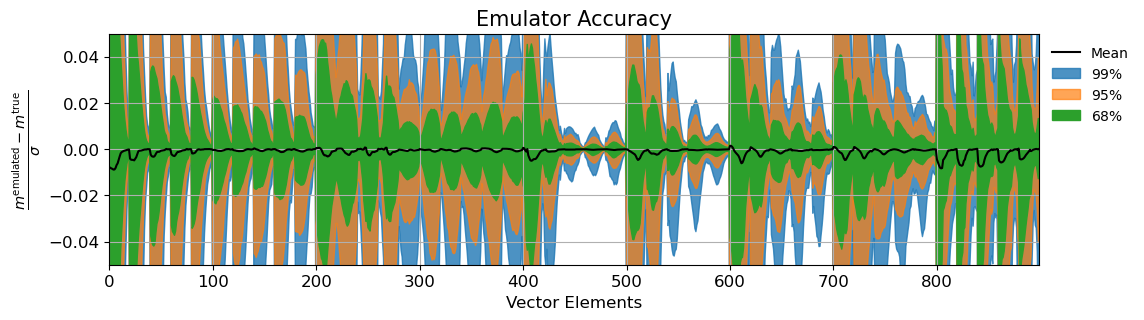

In [17]:
# Computes the standard deviation of the analytical covariance matrix 
std = np.sqrt(np.diag(cov))

# Undoes the normalization performed on the training features 
emulated_features = (cp_nn.predictions_np(test_params) * (np.max(train_features, 
                    axis = 0) - np.min(train_features, axis = 0))) + np.min(train_features, axis = 0)
# Computes something similar to a percent error between the emulated features and test features. Note: this 
# method should be numerically-stable 
diff = (emulated_features - test_features) / std 
# Computes the mean of "diff" for each column  
mean_diff = np.mean(diff, axis = 0)

# Computes the 99th percentile of "diff"
percentiles1 = np.percentile(diff, [0.5, 99.5], axis = 0)
# Computes the 95th percentile of "diff"
percentiles2 = np.percentile(diff, [2.5, 97.5], axis = 0) 
# Computes the 68th percentile of "diff"
percentiles3 = np.percentile(diff, [16, 84], axis = 0)  
bins = range(diff.shape[1])

## Visually demonstrates the emulator's accuracy by showing the predictions within each percentile compared to 
## the mean

plt.figure(figsize = (12, 3), dpi = 100)
plt.title("Emulator Accuracy", fontsize = 15)
plt.plot(bins, mean_diff, color = "k", label = "Mean")
plt.fill_between(bins, percentiles1[0], percentiles1[1], label = '$99\%$', alpha = 0.8, color = "tab:blue")
plt.fill_between(bins, percentiles2[0], percentiles2[1], label = '$95\%$', alpha = 0.7, color = "tab:orange")
plt.fill_between(bins, percentiles3[0], percentiles3[1], label = '$68\%$', alpha = 1.0, color = "tab:green")
plt.xlabel(r"Vector Elements",  fontsize = 12)
plt.ylabel(r"$\frac{m^{\mathrm{emulated}}-m^{\mathrm{true}}}{\sigma}$", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlim(0, max(bins))
plt.ylim(-0.05, 0.05)
plt.grid()
plt.legend(frameon = False, fontsize = 10, loc = "upper left", bbox_to_anchor = (1, 1))
plt.show()

##### Next we want perform a Fisher Analysis using the emualtor. We want you to compute the covariance of the parameters $\Theta = \{\Omega_\mathrm{m},w\}$, which can be estimated by $C(\Theta) = F^{-1}$, where $$F_{ij}= \left(\frac{\partial m(\Theta)}{\partial \Theta_i}\right)^{T} C^{-1} \left(\frac{\partial m(\Theta)}{\partial \Theta_i}\right)$$
##### For the partial derivatives we use the five point stencil beam given by $$\frac{\partial m(\Theta)}{\partial \Theta_i}\approx \frac{-m(\Theta_i + 2\ \Delta \Theta_i) + 8 \ m(\Theta_i +  \Delta \Theta_i) - 8 \ m(\Theta_i - \Delta \Theta_i) + m(\Theta_i - 2\ \Delta \Theta_i)}{12 \ \Delta \Theta_i }$$

In [9]:
# Defines the "delta theta" in the partial derivative formula 
Om_shift = 0.01 
w_shift = 0.01

# Creates a dictionary of parameter values where only Omega_matter varies. Note: the Omega_matter values 
# are centered around 0.3
Om_varied = {"omega_m":[0.3 - (2 * Om_shift), 0.3 - Om_shift, 0.3 + Om_shift, 0.3 + (2 * Om_shift)], 
             "w":[np.mean(test_params["w"])] * 4, "As":[np.mean(test_params["As"])] * 4, 
             "omega_b":[np.mean(test_params["omega_b"])] * 4}
# Creates a dictionary of parameter values where only omega varies. Note: the omega values are centered around -1
w_varied = {"omega_m":[np.mean(test_params["omega_m"])] * 4, 
            "w":[-1 - (2 * w_shift), -1 - w_shift, -1 + w_shift, -1 + (2 * w_shift)], 
            "As":[np.mean(test_params["As"])] * 4, "omega_b":[np.mean(test_params["omega_b"])] * 4}

## Makes predictions using the neural network based on the dictionary of parameter values. Once again, the
## normalization has to be undone

Om_features = (cp_nn.predictions_np(Om_varied) * (np.max(train_features, axis = 0) - np.min(train_features, 
              axis = 0))) + np.min(train_features, axis = 0)
w_features = (cp_nn.predictions_np(w_varied) * (np.max(train_features, axis = 0) - np.min(train_features, 
              axis = 0))) + np.min(train_features, axis = 0)

## Computes the partial derivatives

derivative_Om = (-Om_features[3, :] + (8 * Om_features[2, :]) - (8 * Om_features[1, :]) + Om_features[0, 
                :]) / (12 * Om_shift)
derivative_w = (-w_features[3, :] + (8 * w_features[2, :]) - (8 * w_features[1, :]) + w_features[0,
               :]) / (12 * w_shift)

#### So lets compute the Fisher matrix the corresponding covariance matrix of the paramters:

In [10]:
# Computes the inverse of the analytical covariance matrix 
inv_cov = inv(cov)

## Computes the matrix elements of the Fisher matrix 

FoM_11 = np.matmul(np.transpose(derivative_Om), np.matmul(inv_cov, derivative_Om))
FoM_22 = np.matmul(np.transpose(derivative_w), np.matmul(inv_cov, derivative_w))
# Here, an average is taken of FoM_12 and FoM_21 since they are slightly different
FoM_12 = np.average([np.matmul(np.transpose(derivative_Om), np.matmul(inv_cov, derivative_w)), 
                     np.matmul(np.transpose(derivative_w), np.matmul(inv_cov, derivative_Om))])

# Defines the Fisher matrix 
FoM_best = np.array([[FoM_11,FoM_12],[FoM_12,FoM_22]])
print("Fisher matrix:")
print(FoM_best)

# Defines the covariance matrix of Omega_matter and omega  
cov_parameter = inv(FoM_best)
print("Parameter covariance matrix:")
print(cov_parameter)
print("Standard deviation:")
print(np.sqrt(np.diag(cov_parameter)))

Fisher matrix:
[[4003543.97591742 -244744.98409698]
 [-244744.98409698   18592.36423045]]
Parameter covariance matrix:
[[1.27912325e-06 1.68380415e-05]
 [1.68380415e-05 2.75437063e-04]]
Standard deviation:
[0.00113098 0.0165963 ]


#### First you need to generate the transformation from our model/data vectors to the PCA elements based on the 10k models. Then you need transform all 100k noisy data vectors from which you should then measure the a covariance on the PCA elements. Now it should get clear why you had to genereate the 100k multvariate Gaussian random variables. 

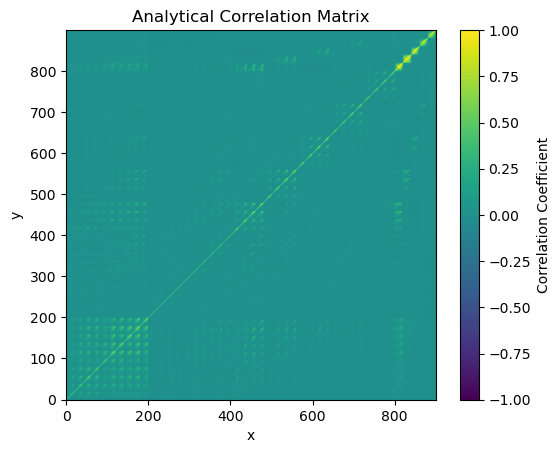

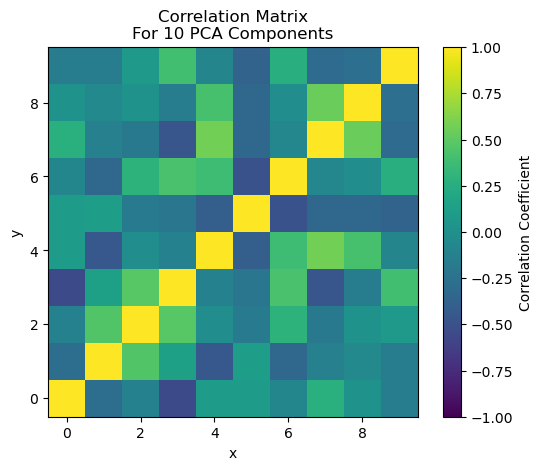

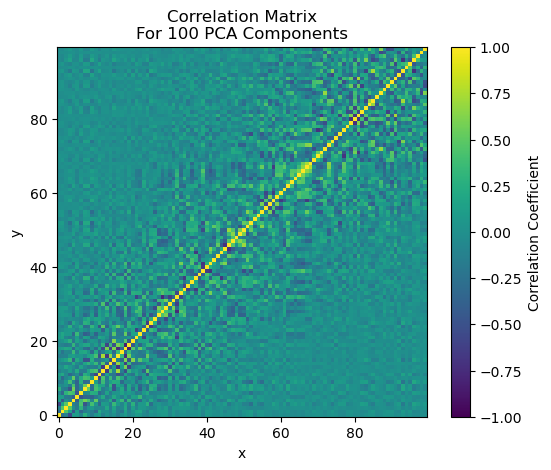

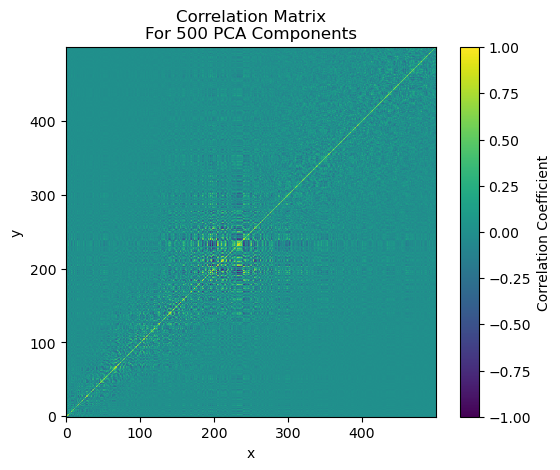

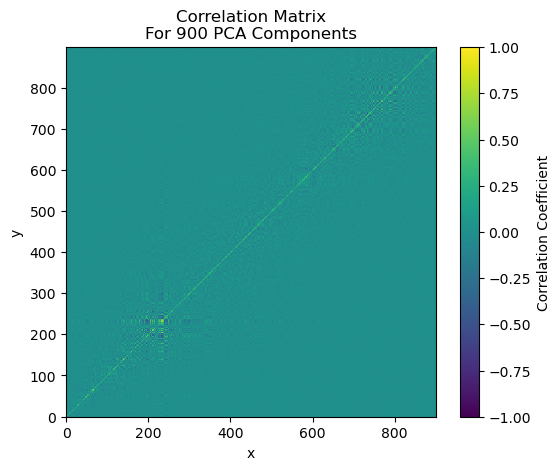

In [11]:
models = np.load("models.npy")
# Computes the mean of our models for each column. This will be subtracted from "models" for numerical 
# stability
mean = np.mean(models, axis = 0) 
# Defines different numbers of PCA eigenvalues 
N_pca = [10, 100, 500, 900]

## Plots the analytical correlation matrix for comparison 

plt.title("Analytical Correlation Matrix", fontsize = 12)
plt.imshow(cov / np.outer(np.sqrt(np.diag(cov)), np.sqrt(np.diag(cov))), vmin = -1, origin = "lower")
plt.xlabel("x", fontsize = 10)
plt.ylabel("y", fontsize = 10)
plt.colorbar(label = "Correlation Coefficient")
plt.show()

for N in N_pca:
    # Performs the dimensionality reduction 
    pca = PCA(n_components = N, svd_solver = "full")
    # Performs the PCA fitting 
    models_pca = pca.fit_transform(models - mean) 
    # Rotates the covariance matrix 
    rotation_matrix = pca.components_.T
    # Computes the PCA covariance matrix 
    cov_pca = np.matmul(rotation_matrix.T, np.matmul(cov, rotation_matrix))

    ## Plots the correlation matrix for a given number of PCA eigenvalues/components
    
    plt.title("Correlation Matrix\nFor " + str(N) + " PCA Components", fontsize = 12)
    plt.imshow(cov_pca / np.outer(np.sqrt(np.diag(cov_pca)), np.sqrt(np.diag(cov_pca))), vmin = -1,
               origin = "lower")
    plt.xlabel("x", fontsize = 10)
    plt.ylabel("y", fontsize = 10)
    plt.colorbar(label = "Correlation Coefficient")
    plt.show()

#### Increase successively the number of PCA elements from which you compute the Fisher matrix. Convince yourself that if you take all possible PCA elements you converge to same contraining power as for original Fisher analysis. How many PCA elements do you need to have 10% and 1% of the constraining power as the original Fisher analysis?

In [14]:
paramter_constraints = []

for N_pca in range(1, diff.shape[1]):
    # Computes the sub covariance matrix for the given number of PCA components and takes its inverse 
    inv_cov_pca = inv(cov_pca[:N_pca, :N_pca])

    # Transforms the features predicted by the neural network and takes the columns up until "N_pca"
    Om_features_pca = pca.transform(Om_features - mean)[:, :N_pca]
    w_features_pca = pca.transform(w_features - mean)[:, :N_pca]
    
    ## The following computes the Fisher matrix and, subsequently, parameter covariance matrix as previously seen 
    
    derivative_Om_pca = (-Om_features_pca[3, :] + (8 * Om_features_pca[2, :]) - (8 * Om_features_pca[1, 
                        :]) + Om_features_pca[0, :]) / (12 * Om_shift)
    derivative_w_pca = (-w_features_pca[3, :] + (8 * w_features_pca[2, :]) - (8 * w_features_pca[1, 
                       :]) + w_features_pca[0, :]) / (12 * w_shift)

    FoM_11_pca = np.matmul(np.transpose(derivative_Om_pca), np.matmul(inv_cov_pca, derivative_Om_pca))
    FoM_22_pca = np.matmul(np.transpose(derivative_w_pca), np.matmul(inv_cov_pca, derivative_w_pca))
    FoM_12_pca = np.average([np.matmul(np.transpose(derivative_Om_pca), np.matmul(inv_cov_pca,
                                                                                  derivative_w_pca)), 
                             np.matmul(np.transpose(derivative_w_pca), np.matmul(inv_cov_pca, 
                                                                                 derivative_Om_pca))])
    
    FoM_best_pca = np.array([[FoM_11_pca, FoM_12_pca], [FoM_12_pca, FoM_22_pca]])

    cov_parameter_pca = inv(FoM_best_pca)
    # Appends the standard deviation of each parameter (Omega_matter and omega) to a list 
    paramter_constraints.append(np.sqrt(np.diag(cov_parameter_pca)))
    
parameter_constraints = np.array(paramter_constraints)
# Defines the standard deviations for Omega_matter
Om_constraints = parameter_constraints[:, 0]
# Defines the standard deviations for omega 
w_constraints = parameter_constraints[:, 1]

print("Omega_matter standard deviation using all PCA elements:", Om_constraints[-1])
print("Omega_matter standard deviation from the Fisher analysis:", np.sqrt(np.diag(cov_parameter))[0])
print("omega standard deviation using all PCA elements:", w_constraints[-1])
print("omega standard deviation from the Fisher analysis:", np.sqrt(np.diag(cov_parameter))[1])

Omega_matter standard deviation using all PCA elements: 0.001130991664792323
Omega_matter standard deviation from the Fisher analysis: 0.0011309833132389085
omega standard deviation using all PCA elements: 0.01659668761492171
omega standard deviation from the Fisher analysis: 0.016596296670807042


By comparing the standard deviations using all possible PCA elements to the Fisher analysis, we can see that, indeed, we converge\
to the same constraining power as the original Fisher analysis.

In [15]:
## Applies factors to the Fisher analysis standard deviations for computing the number of PCA elements 
## needed to have 10% and 1% of the constraining power

fisher_10_Om = 1.1 * np.sqrt(np.diag(cov_parameter))[0]
fisher_1_Om = 1.01 * np.sqrt(np.diag(cov_parameter))[0]
fisher_10_w = 1.1 * np.sqrt(np.diag(cov_parameter))[1]
fisher_1_w = 1.01 * np.sqrt(np.diag(cov_parameter))[1]

N_pca_Om_fisher = []
N_pca_w_fisher = []

# Iterates through the factors applied to Omega_matter's standard deviation 
for val in [fisher_10_Om, fisher_1_Om]:
    # Iterates through the PCA standard deviations 
    for i, std in enumerate(Om_constraints):
        # If a standard deviation is less than or equal to the Fisher analysis standard deviation * some
        # factor, then the for loop is broken and the corresponding PCA element number is appended to a list 
        if std <= val:
            N_pca_Om_fisher.append(i + 1)
            break

# Iterates through the factors applied to omega's standard deviation  
for val in [fisher_10_w, fisher_1_w]:
    for i, std in enumerate(w_constraints):
        if std <= val:
            N_pca_w_fisher.append(i + 1)
            break
            
print("PCA elements needed to have 10% of the constraining power as the original Fisher analysis:", 
      N_pca_Om_fisher[0], "(Omega_matter)")
print("PCA elements needed to have 1% of the constraining power as the original Fisher analysis:", 
      N_pca_Om_fisher[1], "(Omega_matter)")
print("PCA elements needed to have 10% of the constraining power as the original Fisher analysis:", 
      N_pca_w_fisher[0], "(omega)")
print("PCA elements needed to have 1% of the constraining power as the original Fisher analysis:", 
      N_pca_w_fisher[1], "(omega)")

PCA elements needed to have 10% of the constraining power as the original Fisher analysis: 58 (Omega_matter)
PCA elements needed to have 1% of the constraining power as the original Fisher analysis: 346 (Omega_matter)
PCA elements needed to have 10% of the constraining power as the original Fisher analysis: 126 (omega)
PCA elements needed to have 1% of the constraining power as the original Fisher analysis: 529 (omega)


### Plot the constraints depending on the number of PCA that you have used. How many PCA elements do you need to get 10% and 1% of the maximum constraining power.

PCA elements needed to have 10% of the max constraining power: 58 (Omega_matter)
PCA elements needed to have 1% of the max constraining power: 346 (Omega_matter)
PCA elements needed to have 10% of the max constraining power: 126 (omega)
PCA elements needed to have 1% of the max constraining power: 529 (omega)


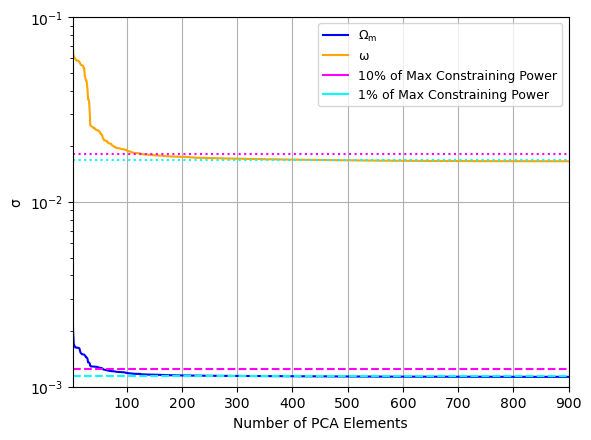

In [16]:
## The following block of code repeats the previous cell, but uses the standard deviations corresponding 
## to 900 PCA elements instead of the Fisher analysis standard deviations. Note: the standard deviations 
## corresponding to 900 PCA elements define the max constraining power

max_10_Om = 1.1 * Om_constraints[-1]
max_1_Om = 1.01 * Om_constraints[-1]
max_10_w = 1.1 * w_constraints[-1]
max_1_w = 1.01 * w_constraints[-1]

N_pca_Om_max = []
N_pca_w_max = []

for val in [max_10_Om, max_1_Om]:
    for i, std in enumerate(Om_constraints):
        if std <= val:
            N_pca_Om_max.append(i + 1)
            break
            
for val in [max_10_w, max_1_w]:
    for i, std in enumerate(w_constraints):
        if std <= val:
            N_pca_w_max.append(i + 1)
            break
            
print("PCA elements needed to have 10% of the max constraining power:", N_pca_Om_max[0], "(Omega_matter)")
print("PCA elements needed to have 1% of the max constraining power:", N_pca_Om_max[1], "(Omega_matter)")
print("PCA elements needed to have 10% of the max constraining power:", N_pca_w_max[0], "(omega)")
print("PCA elements needed to have 1% of the max constraining power:", N_pca_w_max[1], "(omega)")

## Plots the standard deviation as a function of number of PCA elements 

plt.plot(range(1, diff.shape[1]), Om_constraints, color = "blue", label = r"$\mathrm{\Omega_{m}}$")
plt.plot(range(1, diff.shape[1]), w_constraints, color = "orange", label = r"$\mathrm{\omega}$")
plt.plot([], [], color = "magenta", label = "10% of Max Constraining Power")
plt.plot([], [], color = "cyan", label = "1% of Max Constraining Power")
plt.hlines(max_10_Om, 2, 900, color = "magenta", linestyle = "--")
plt.hlines(max_1_Om, 2, 900, color = "cyan", linestyle = "--")
plt.hlines(max_10_w, 2, 900, color = "magenta", linestyle = "dotted")
plt.hlines(max_1_w, 2, 900, color = "cyan", linestyle = "dotted")
plt.xlabel("Number of PCA Elements", fontsize = 10)
plt.ylabel(r"$\mathrm{\sigma}$", fontsize = 10)
# Shows points past N_pca = 2. At N_pca = 1, the plots shoot up, making some features hard to see
plt.xlim(2, 900)
plt.ylim(1e-3, 1e-1)
plt.yscale("log")
plt.legend(loc = "best", fontsize = 9)
plt.grid()

Note: the number of PCA elements needed to have 10% or 1% of the constraining power as the original Fisher analysis and the max\
constraining power are the same. This is because the standard deviations from the Fisher analysis and using PCA are very close to\
each other. The percent error for Omega_matter is around 7.4e-4%, while the percent error for omega is approximately 2.4e-3%. It is\
no surprise that the standard deviations are so close since PCA with 900 elements is essentially not applying the PCA. So, comparing\
the max constraining power to the constraining power from the original Fisher analysis serves as a sanity check, and it is\
encouraging that we got the same number of PCA elements.

From this exercise we see that we can use a fraction of the max PCA elements to constrain standard deviations pretty well.